<a href="https://colab.research.google.com/github/cleitonmoya/MAE001_Trabalho1/blob/main/Trab1_MAE001_Cleiton_Felipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução
O objetivo deste trabalho é explorar modelos para a simulação de valores de ações e precificação de contratos de opções.

Para a simulação do valor da ação utlizamos o **Modelo Binomial**. Na seção 1, calibramos este modelo usando uma série de dados real do mercado financeiro (WEGE3). Alteramos então a escala de tempo utilizando o **Modelo de Jarrow e Rudd** (JR).

Na seção 2, exploramos a precificação de contratos não-vanilla através do **Método Monte Carlo**. Primeiramente,  precificamos um **put asiático-europeu**. Depois, alteramos este contrato de forma a torná-lo um  contrato exótico do tipo **put asiático com barreira knock-out (drow-and-out)**. Precificamos este contrato com o mesmo método (Monte Carlo), observando a influência da barreira no preço do contrato.

#1. Calibração do Modelo Binomial e Simulações do Preço da Ação

Utilizamos a série histórica de preços da ação da WEG (**WEGE3**) do período de 01.01.2019 a 31.01.2020 (4 meses). 

Os dados foram obtidos através da plataforma *Profit Trader Clear* (https://www.clear.com.br/site/plataformas/profit-trader-clear), a qual permite a exportação para um arquivo .csv.  O arquivo CSV foi disponibilizado no GitHub e então carregado ao com o auxílio da biblioteca Pandas.

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/cleitonmoya/MAE001_Trabalho1/main/WEGE3.csv'
df = pd.read_csv(url, index_col=0, dayfirst=True, parse_dates=True)
df.sort_index(inplace=True)
df = df.loc['2019-09-01':'2020-01-31']
S = df.Fechamento.values

Visualização da série de dados:

In [204]:
df

,Abertura,Máxima,Mínima,Fechamento
Data,,,,
2019-09-02,22.29,22.81,22.08,22.56
2019-09-03,22.60,22.89,21.98,21.98
2019-09-04,22.29,22.49,22.14,22.41
2019-09-05,22.60,22.92,22.53,22.56
2019-09-06,22.78,22.87,22.40,22.62
...,...,...,...,...
2020-01-27,40.51,41.45,39.54,40.68
2020-01-28,40.66,42.10,40.44,41.71
2020-01-29,42.06,43.96,42.06,42.09


##a) Jumps
Cálculo do vetor de <i>jumps</i> ($J$), média ($m$) e desvio-padrão da amostra ($s$):

In [205]:
J = S[1:]/S[:-1]
m = J.mean()
s = J.std(ddof=1)
N = len(S)
print("Dias:", N)
print("Média:", m)
print("Desvio padrão:", s)

Dias: 104
Média: 1.0055247064122146
Desvio padrão: 0.01821171150812842


##b) Gráfico da Série de Preços e Crescimento Médio

Calculamos o crescimento médio utilizando a fórmula $t_{i+1}=m \times t_i$.

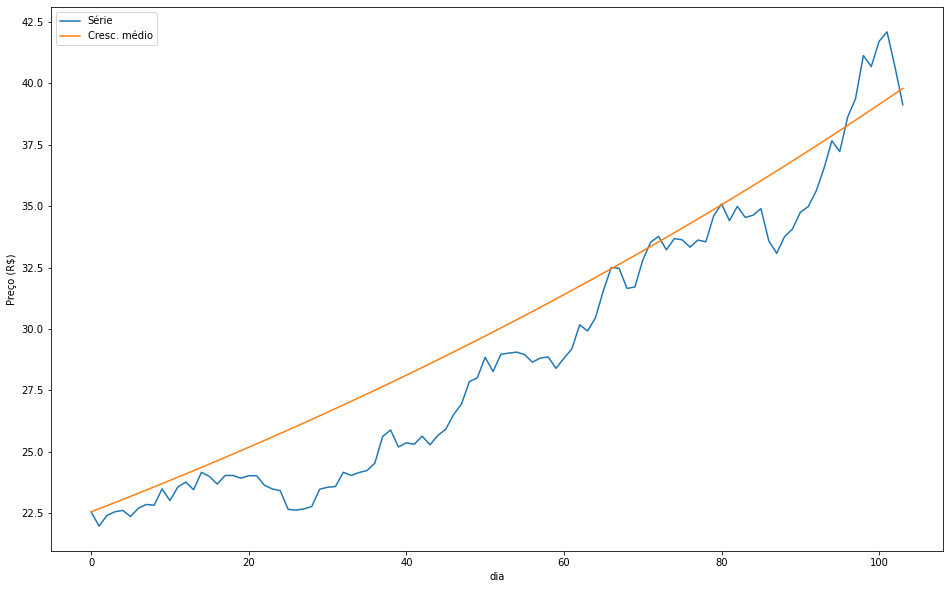

In [206]:
plt.figure(figsize=(16,10))
t = np.array([S[0]])
for n in range(1,N):
    t = np.append(t,t[n-1]*m)

plt.plot(S,label='Série')
plt.plot(t,label='Cresc. médio')
plt.xlabel("dia")
plt.ylabel("Preço (R$)")
plt.legend()
plt.show()

Podemos observar que a curva de crescimento médio (exponcencial) se ajustou bem à dinâmica da ação no período. Além disso, o formato exponencial da curva de crescimento médio quase não é percepível no gráfico devido à janela de tempo utilizada. Se fizermos uma extrapolação (predição) dos preços com uma janela futura maior, 100 dias à frente, esta caracteristica exponencial pode ser melhor visualizada:

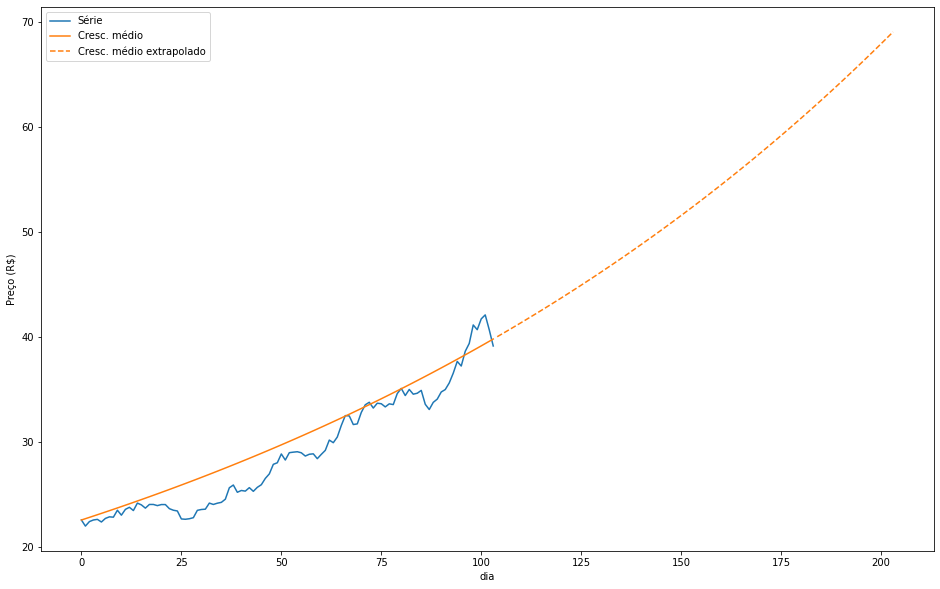

In [207]:
plt.figure(figsize=(16,10))
t = np.array([S[0]])
for n in range(1,N+100):
    t = np.append(t,t[n-1]*m)

plt.plot(S,label='Série')
plt.plot(t[:N],label='Cresc. médio')
plt.plot(range(N,N+100),t[N:], linestyle='--', color='C1', label='Cresc. médio extrapolado')
plt.xlabel("dia")
plt.ylabel("Preço (R$)")
plt.legend()
plt.show()

## c) Gráfico das séries logarítmicas 

Neste item plotamos aplicamos o logaritmo (base 10) nas séries $S$ e $t$. Como o crescimento médio é exponencial, quando aplicamos o logaritmo o mesmo se torna uma reta, ficando melhor a visualização no gráfico com escala log.

Coeficiente angular: 0.002322046141644421


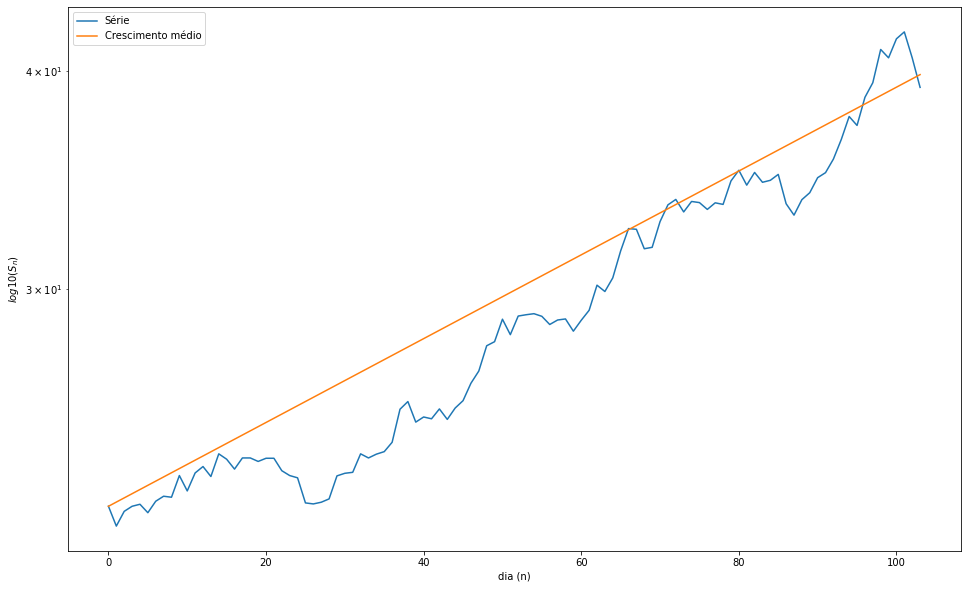

In [208]:
from numpy import log10
plt.figure(figsize=(16,10))

t = np.array([S[0]])
for n in range(1,N):
    t = np.append(t,t[n-1]*m)

plt.plot(S,label='Série')
plt.plot(t,label='Crescimento médio')
plt.xlabel("dia (n)")
plt.ylabel("$log10(S_n)$")
plt.yscale('log')
plt.legend()
#plt.ylim(20, 45)
b = (log10(S[N-1])-log10(S[0]))/(N-1)
print("Coeficiente angular:", b)
plt.show()

## d) Simulação de Caminhos

Para fazer a simulação dos caminhos, primeiramente precisamos calcular os valores de $u$ e $d$:

In [209]:
u = m + s
d = m - s
print("u:", u)
print("d:", d) 

u: 1.023736417920343
d: 0.9873129949040862


Simulamos 5 caminhos partindo de $S_0$. Nas simulações, adotamos $p=1/2$ (modelo JR). 

Para fins de reprodutibilidade e possível conferência futura dos resultados, utilizamos uma semente (*seed*) para a geração dos números pseudo-aleatórios.

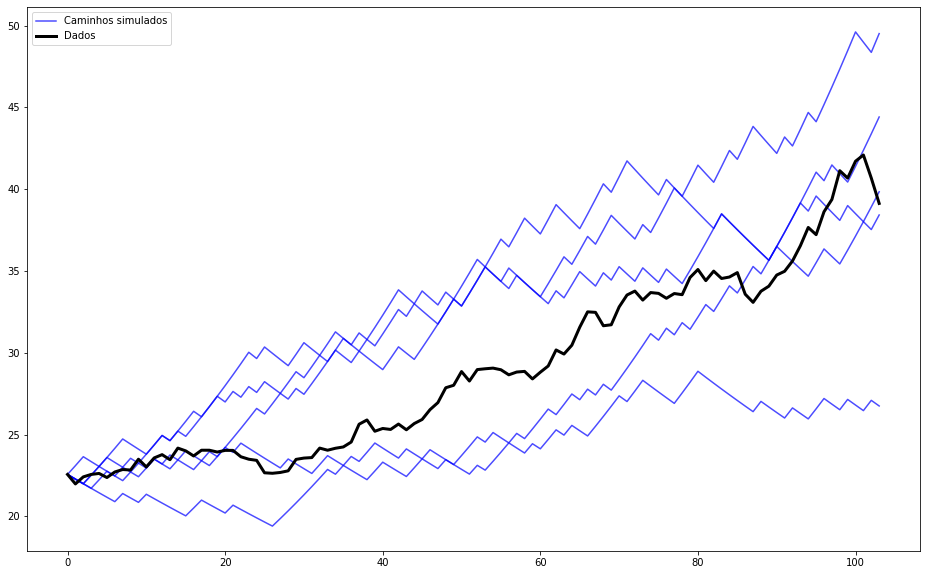

In [210]:
import random
plt.figure(figsize=(16,10))
random.seed(1000)
p = 1/2
for k in range(5):
    S1 = np.array([S[0]])
    sn = S[0]
    
    for n in range(1,len(S)):
        if (random.random() < p):
            sn = sn*u
        else:
            sn = sn*d
        S1 = np.append(S1,sn)

    if k==0:    
      plt.plot(S1, color='b', alpha=0.7, label="Caminhos simulados")
    else:
      plt.plot(S1, color='b', alpha=0.7)
plt.plot(S,color='k', linewidth=3, label="Dados")
plt.legend()
plt.show()

## e) Mudança da Escala de Tempo

Calculamos os novos parâmetros através do método JR.
Para determinarmos a taxa de juros, utilizamos o valor acumulado da taxa Selic no período de 01-09-2019 a 31-01-2020. Obtivemos este valor do site/aplicativo "Calculador do Cidadão", do BCB: https://www3.bcb.gov.br/CALCIDADAO.

Convertemos então a taxa de juros para a base diária, a fim de obtermos a taxa média do período>


In [211]:
r_per = 0.02074539 # Fonte: BCB - Calculadora do Cidadão
n_dias = len(S)
r = (1+r_per)**(1/n_dias)-1
print("Taxa de juros:",r)

Taxa de juros: 0.0001974534809912054


Verficando a condição de não-arbitragem: $d < (1+r) < u$ 

In [212]:
if (u>1+r) and (d<1+r):
  print("Condição satisfeita!")
else:
  print("Condição não satisfeita!")

Condição satisfeita!


Calculando os novos parâmetros para $\Delta T=1/10$ através do método JR:

In [213]:
dT = 1/10
s = np.sqrt((m**2+s**2)**dT-(m**2)**dT)
m = m**dT
u = m + s
d = m - s

print("u:", u)
print("d:", d)

u: 1.0062812420267497
d: 0.9948209618148245


Checando novamente a condição de não-arbitragem para o novo intervalo:

In [214]:
if (u>1+r) and (d<1+r):
  print("Condição satisfeita!")
else:
  print("Condição não satisfeita!")

Condição satisfeita!


Plotando os caminhos:

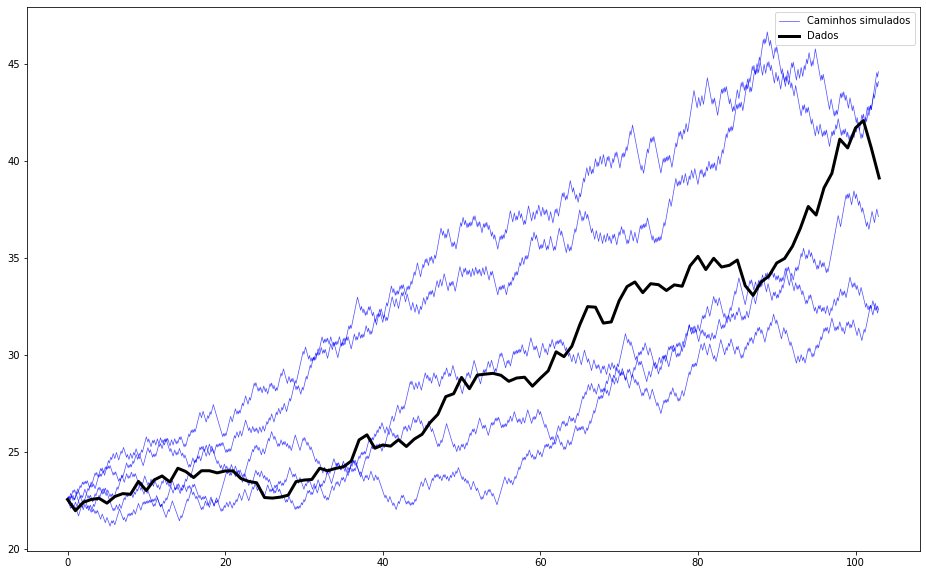

In [215]:
random.seed(1000)
plt.figure(figsize=(16,10))
p = 1/2
T = len(S)
for k in range(5):
    S1 = np.array([S[0]])
    sn = S[0]
    
    for n in np.arange(dT,T-1,dT):
        if (random.random() < p):
            sn = sn*u
        else:
            sn = sn*d
        S1 = np.append(S1,sn)

    if k==0:    
      plt.plot(np.arange(0,T-1,dT), S1, color='b', linewidth=0.7, alpha=0.7, label="Caminhos simulados")
    else:
      plt.plot(np.arange(0,T-1,dT), S1, color='b', linewidth=0.7, alpha=0.7)
plt.plot(range(0,len(S)),S,color='k', linewidth=3, label="Dados")
plt.legend()
plt.show()

# 2. Método de Monte Carlo

Neste item, fazemos a precificação de um contrato do tipo **put europeu-asiático** com *strike* $K=45$ utilizando o método de Monte Carlo e o modelo binomial. Os parâmetros do modelo foram fornecidos pelo enunciado.

In [216]:
S0 = 10
r = 0.01
N = 40
u = 1.13
d = 0.85
K = 45

def put(K,S):
  Sm = S.mean()
  if K > Sm:
    return K-Sm
  else:
    return 0

Primeiramente, necessitamos verificar a auseência de arbitragem no modelo:

In [217]:
if (u>1+r) and (d<1+r):
  print("Condição de não-arbitragem satisfeita!")
else:
  print("Condição não satisfeita!")

Condição de não-arbitragem satisfeita!


Probabilidade neutra a risco $p$:

In [218]:
p = (1+r-d)/(u-d)
print("p:",p)

p: 0.5714285714285717


Precisamos então gerar caminhos para o preço da ação.

In [219]:
def gera_caminho(N, S0, u, d, r):
  p = (1+r-d)/(u-d)
  s = np.zeros(N)
  s[0] = S0
  for i in range(1,N):
    if random.random() < p:
      s[i] = u*s[i-1]
    else:
      s[i] = d*s[i-1]
  return s

A fim realizar uma análise gráfica preliminar do modelo e seus parâmetros, simulamos $200$ caminhos. Calculamos então o caminho médio com o objetivo de termos uma noção preliminar do preço médio esperado para a ação e, por conseguinte, do preço médio esperado para o contrato.

In [220]:
s = np.zeros(N+1)
for n in range(200):
  S = gera_caminho(N+1, S0, u, d, r)
  s = np.vstack((s,S))
s = s[1:]

S_N médio: 15.330396831993962


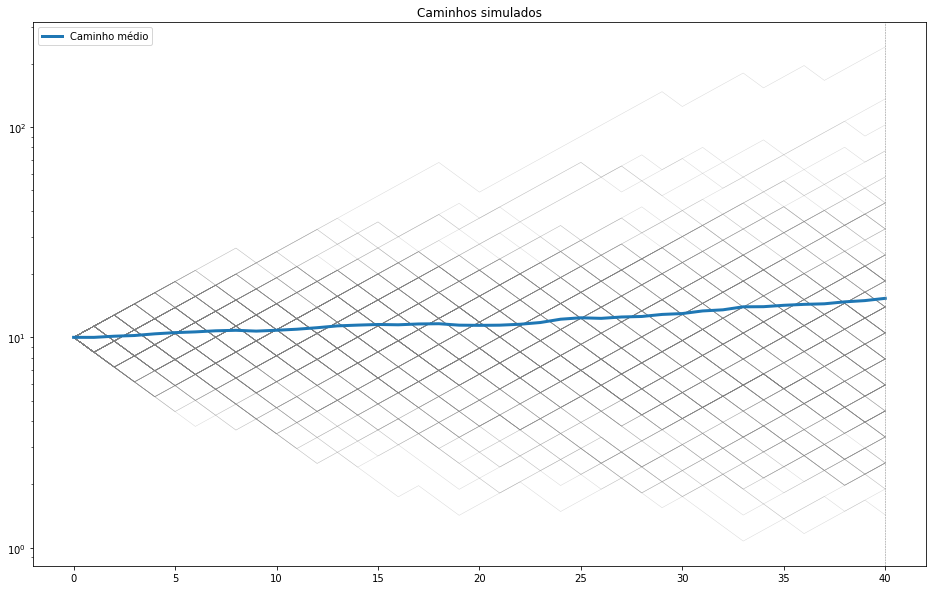

In [221]:
plt.figure(figsize=(16,10))
Sm = s.mean(0)

plt.title("Caminhos simulados")
plt.plot(s.T,linewidth=0.5, alpha=0.3, color='grey')
plt.plot(Sm,linewidth=3, label="Caminho médio")
plt.axvline(N, linewidth=0.5, linestyle='--', color='gray')
plt.yscale('log')
plt.legend()
print("S_N médio:",Sm[N])

Estimativa preliminar do preço do contrato com base no caminho médio do preço da ação:

In [222]:
print('Valor médio ao longo do caminho médio:', Sm.mean())
print('Vn call:', call(K,Sm.mean()))
print('Vn put:', put(K,Sm.mean()))

D = 1/(1+r)**N
print('D:',D)
print('V0 put:', D*put(K,Sm.mean()))

Valor médio ao longo do caminho médio: 12.051729856446082
Vn call: 0
Vn put: 32.94827014355392
D: 0.6716531388604381
V0 put: 22.129809061939646


Precificação pelo método de Monte Carlo:

In [223]:
# Precificação de contrato - Método de Monte Carlo
def monte_carlo(S0, MAX, N, u, d, r ,g, ret_cam):

  D = 1/(1+r)**N
  soma = 0
  if ret_cam == False: # Caso não se deseje retornar o caminho
    for m in range(MAX):
      s = gera_caminho(N+1, S0, u, d, r)
      soma =  soma + D*g(K,s)
    V0 = soma/MAX
    return V0
  else: # Armazena e retorna os caminhos
    s = np.zeros(N+1)
    for m in range(MAX):
      sm = gera_caminho(N+1, S0, u, d, r)
      soma =  soma + D*g(K,sm)
      s = np.vstack((s, sm))
    s = s[1:]
    V0 = soma/MAX
    return V0,s

Execução do experimento (usando MAX=100000 para critério de comparação):

In [224]:
random.seed(1000)
MAX = np.array([200, 400, 800, 1600,100000])
nit = 25 # número de iterações

#VC = monte_carlo(S0, 100000, N, u, d, r, put, ret_cam=False)

V0 = np.zeros(len(MAX))
for k, max in enumerate(MAX):   
  # Executa o Monte-Carlo nit vezes 
  soma = 0
  for n in range(nit):
    soma = soma + monte_carlo(S0, max, N, u, d, r, put, ret_cam=False)
  V0[k] = soma/n

VO = V0[-1]
print("V0:", V0)

V0: [22.99915039 22.96098226 22.95930317 22.95372456 22.91507127]


Cálculo do erro relativo médio e do erro absoluto médio:

In [225]:
erro = abs((V0-VO)/VO)
print("Erro:", erro)

erro_abs = abs(V0-VO)
print("Erro absoluto:", erro_abs)

Erro: [0.00366916 0.00200353 0.00193025 0.00168681 0.        ]
Erro absoluto: [0.08407912 0.04591099 0.04423191 0.03865329 0.        ]


## b,c) Gráfico do Erro Relativo Médio e Estimativa da Ordem de Convergência 

Primeiramente um gráfico com os primeiros dados da simulação:

slope: -0.341722    intercept: -1.714624
R-squared: 0.783717


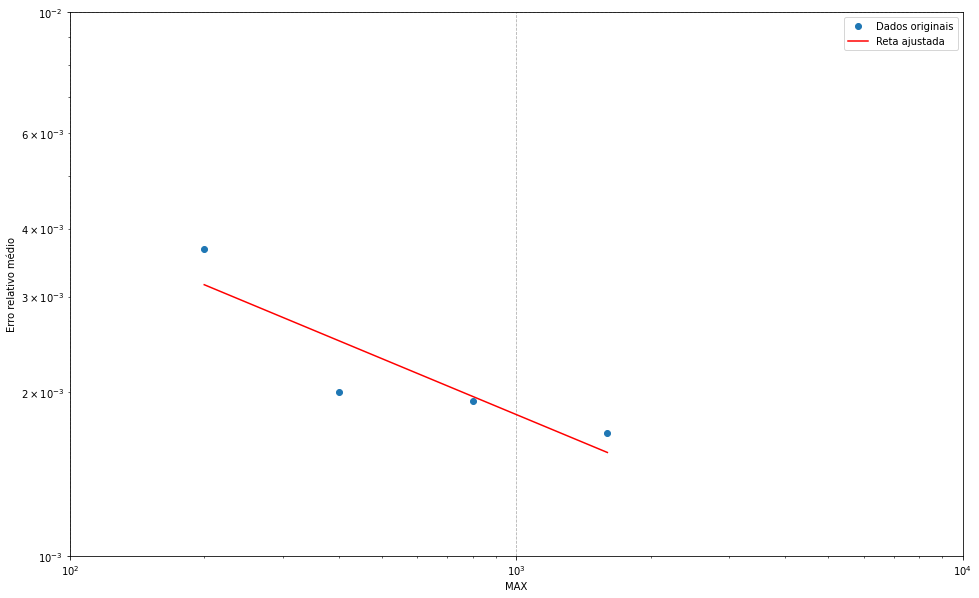

In [226]:
plt.figure(figsize=(16,10))

plt.loglog(MAX,erro,'o',label='Dados originais')
plt.xlabel('MAX')
plt.ylabel('Erro relativo médio')
plt.xlim(10**2,10**4)
plt.ylim(10**-3, 10**-2)
plt.grid(linestyle='--')

# Regressão linear
x = log10(MAX[:-1])
y = log10(erro[:-1])
x2=MAX[:-1]
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
plt.plot(x2, 10**(intercept+ slope*x), label='Reta ajustada', color='r')
plt.legend()
plt.show()

Vamos adicionar mais pontos ao gráfico:

In [227]:
random.seed(1000)
NEW_MAX = 100*(2**np.arange(1,10,1))
print("Novos MAX:", NEW_MAX)
nit = 25 # número de iterações

V0 = np.zeros(len(NEW_MAX))
for k, max in enumerate(NEW_MAX):   
  # Executa o Monte-Carlo nit vezes 
  soma = 0
  for n in range(nit):
    soma = soma + monte_carlo(S0, max, N, u, d, r, put, ret_cam=False)
  V0[k] = soma/n
print("V0:", V0)

Novos MAX: [  200   400   800  1600  3200  6400 12800 25600 51200]
V0: [22.99915039 22.96098226 22.95930317 22.95372456 22.89994192 22.91456132
 22.90844719 22.92003307 22.9161774 ]


In [228]:
erro = abs((V0-VO)/VO)
print("Erro:", erro)

erro_abs = abs(V0-VO)
print("Erro absoluto:",erro_abs)

Erro: [3.66916246e-03 2.00352809e-03 1.93025397e-03 1.68680655e-03
 6.60235680e-04 2.22535832e-05 2.89070882e-04 2.16530007e-04
 4.82708358e-05]
Erro absoluto: [0.08407912 0.04591099 0.04423191 0.03865329 0.01512935 0.00050994
 0.00662408 0.0049618  0.00110613]


slope: -0.772417    intercept: -0.622967
R-squared: 0.677408


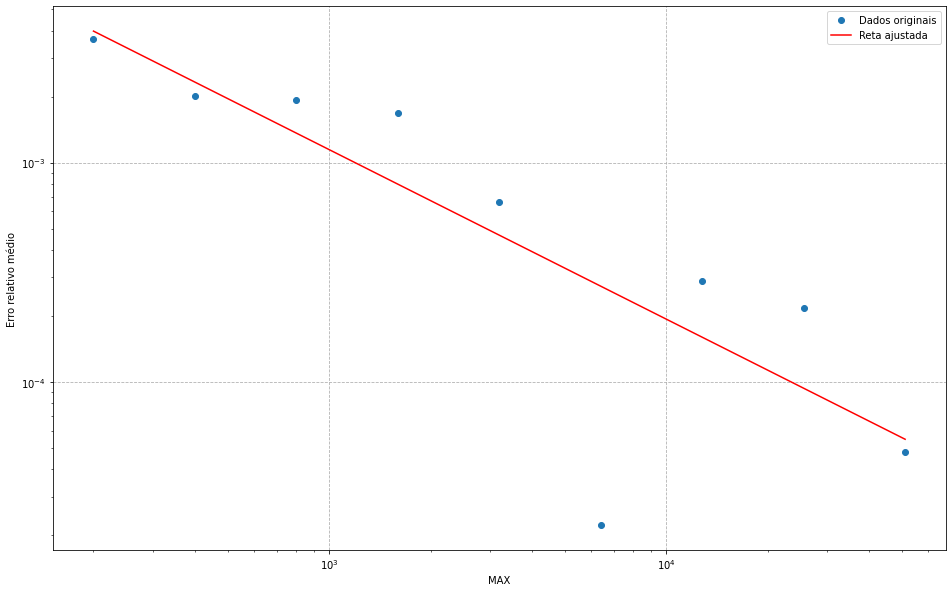

In [229]:
plt.figure(figsize=(16,10))

plt.loglog(NEW_MAX,erro,'o',label='Dados originais')
plt.xlabel('MAX')
plt.ylabel('Erro relativo médio')
plt.grid(linestyle='--')

# Regressão linear
x = log10(NEW_MAX)
y = log10(erro)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
plt.plot(NEW_MAX, 10**(intercept+ slope*x), label='Reta ajustada', color='r')
plt.legend()
plt.show()

Fazendo uma pequena correção na reta:

In [230]:
correcao = list(erro[:5])+list(erro[6:-1])

new_ax = [200, 400, 800, 1600, 3200, 12800, 25600]

slope: -0.592860    intercept: -1.050090
R-squared: 0.960486


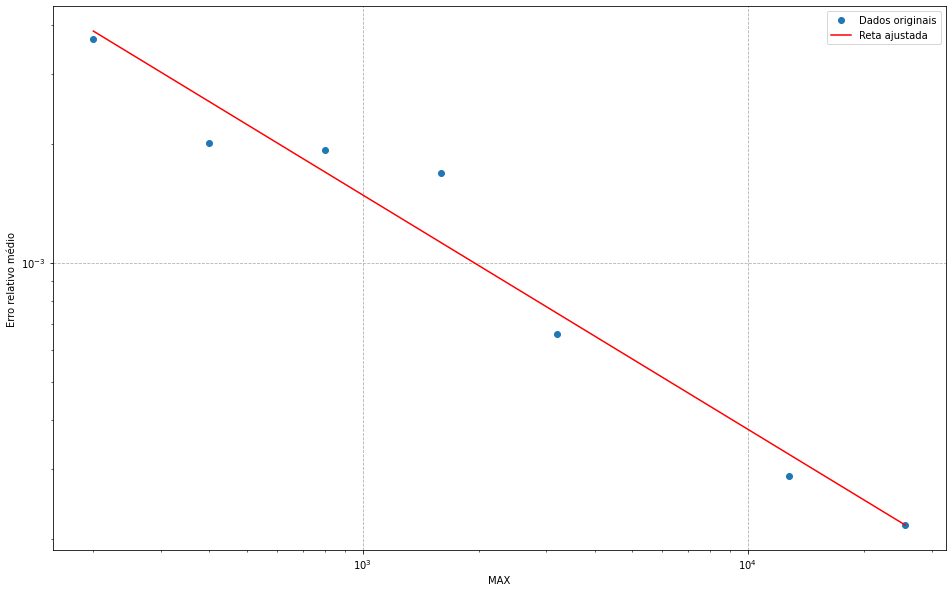

In [231]:
plt.figure(figsize=(16,10))

plt.loglog(new_ax,correcao,'o',label='Dados originais')
plt.xlabel('MAX')
plt.ylabel('Erro relativo médio')
plt.grid(linestyle='--')

# Regressão linear
x = log10(new_ax)
y = log10(np.array(correcao))
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
plt.plot(new_ax, 10**(intercept+ slope*x), label='Reta ajustada', color='r')
plt.legend()
plt.show()

Podemos verificar nos gráficos que o coeficiente angular da reta (*slope*) é aproximadamente $-0.5$ e, portanto, a ordem de convergência do algoritmo dé próxima a $0.5$. Ou seja, o erro relativo se reduz na proporção da metade do aumento do número de caminhos simulados (iterações). 

## d) Put Asiático com Barreira *Knock-Out* (*Down-and-Out*)

Definição do Put com barreira.
Se durante o caminho o ação ultrapassar a barreira (preço abaixo), o contrato perde o valor (*down-and-out*).
Utilizamos inicialmente uma barreira $B=5$.

In [232]:
B = 5
def put_barreira(K,S):
  Sm = S.mean()
  if (K > Sm) and (S>=B).all():
    return K-Sm
  else:
    return 0

Simulação do preço do contrato através de Monte Carlo:

In [233]:
random.seed(1000)
V0, s = monte_carlo(S0, 200, N, u, d, r, put_barreira, ret_cam=True)
print("V0",V0)

V0 11.656211578225893


Visualização dos caminhos simulados e da barreira:

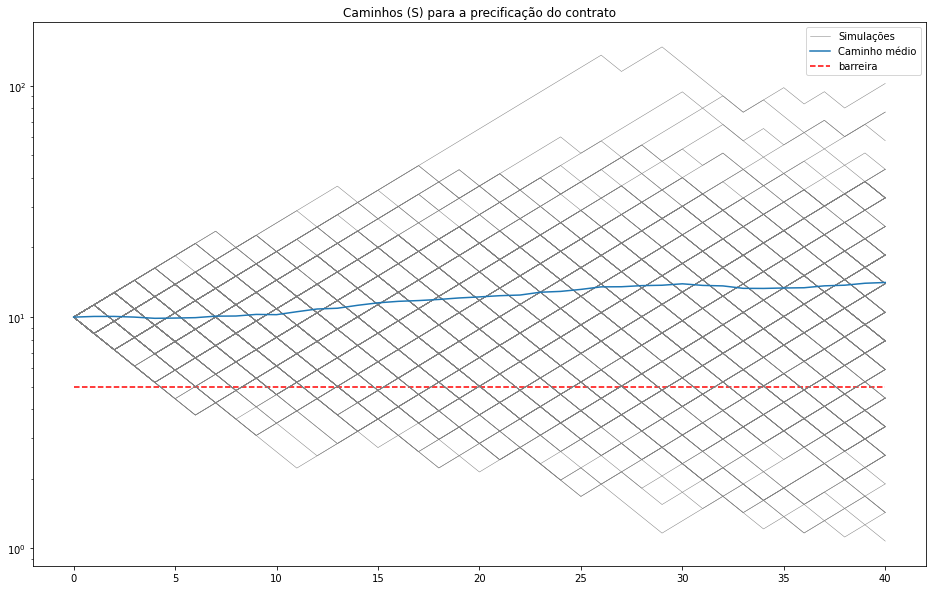

In [234]:
plt.figure(figsize=(16,10))
plt.title('Caminhos (S) para a precificação do contrato')
plt.plot(s[0].T, linewidth=0.5, color='grey', label='Simulações')
plt.plot(s[1:].T, linewidth=0.5, color='grey')
plt.plot(s.mean(0), label='Caminho médio')
plt.hlines(y=B, xmin=0, xmax=40, color='r', linestyle='--', label='barreira')
plt.yscale('log')
plt.legend()


Obsevamos que, com uma barreira $B=5$, o valor do contrato é diminuído aproximadamente pela metade.

Para melhor visualizarmos influência da bareira, fizemos simulações variando a barreira no intervalo de $1$ a $20$.

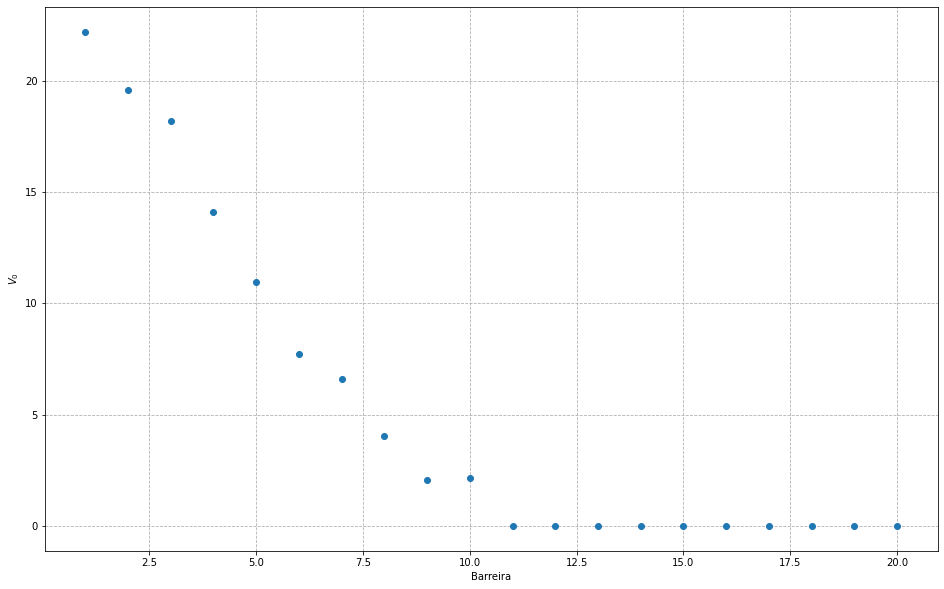

In [235]:
B = range(1,21)

def put_barreira(K,S):
  Sm = S.mean()
  if (K > Sm) and (S>=B).all():
    return K-Sm
  else:
    return 0

random.seed(1000)
plt.figure(figsize=(16,10))
for _,b in enumerate(B):

  def put_barreira(K,S):
    Sm = S.mean()
    if (K > Sm) and (S>=b).all():
      return K-Sm
    else:
      return 0

  V0 = monte_carlo(S0, 200, N, u, d, r, put_barreira, ret_cam=False)
  plt.plot(b,V0,'o', color='C0')
  plt.xlabel('Barreira')
  plt.ylabel('$V_0$')
  plt.grid(linestyle='--')

Observamos que o preço do contrato diminui com o aumento da barreira. Desta forma, barreira serve como uma espécie de limitação do valor do contrato, amenizando uma eventual perda ao lançador do *put*.

# Conclusões



Neste trabalho exploramos modelos para simulação de valores de ação e precificação de contratos de opções. 

Primeiramente observamos que o Modelo Binomial calibrado pelo método de JR se ajustou bem ao ativo e período selecionado para o trabalho. Porém, convém observar que isso ocorreu porque escolhemos propositadamente uma ação e período com crescimento exponencial. Na prática, isso nem sempre ocorre. 

Observamos também que o Modelo Binomial e o Método de Monte Carlo, apesar de relativamente simples e de fácil implementação, conseguem precificar diversos tipos de contratos, não se limitando aos contratos *vanilla*. Assim, concluímos que são modelos bastante interessantes para aplicações práticas.

# Bibliografia

Cabral, M. A. P. **Finanças Matemáticas**: Teoria e Prática. 1 ed. 2020. Disponível em: Disponível em https://sites.google.com/matematica.ufrj.br/mapcabral/livro-finanças-matemática.